# Visualizing Electron Density, Electrostatic Potential, and Orbitals

This exercise is based on Lab 5 of [Computational Chemistry for Chemistry Educators](http://www.computationalscience.org/ccce/about/labs/labs.php).

# Part 0 - Setting up the appropriate software

In [ ]:
#@title Install packages with pip
#@markdown pyscf (Python-based Simulations of Chemistry Framework), for QM electronic structure calculation \\
#@markdown jsme_notebook, to sketch structures \\
#@markdown pyberny, for optimization \\
#@markdown geometric, for optimization \\
#@markdown condacolab, to install other packages \\
#@markdown
#@markdown Installing condacolab will restart the kernel and you can continue with the next cell.

!pip install pyscf
!pip install git+https://github.com/pyscf/semiempirical
!pip install -U pyberny
!pip install geometric
!pip install jsme_notebook

try:
    import google.colab
    !pip install condacolab
    import condacolab
    condacolab.install_mambaforge()
except ModuleNotFoundError:
    pass

In [ ]:
#@title Install packages with conda
#@markdown rdkit, to generate initial structures from SMILES strings \\
#@markdown py3Dmol, for visualization of structures \\

try:
    import condacolab
    condacolab.check()
    !mamba install --yes -c conda-forge rdkit py3Dmol
except ModuleNotFoundError:
    on_colab = False
else:
    #check if installation was succesful
    try:
        import rdkit
        on_colab = True
        from IPython.display import clear_output
        clear_output()  # clear the excessive installation outputs
        print("Dependencies successfully installed!")
    except ModuleNotFoundError:
        print("Error while installing dependencies!")

# SMILES string tool

In [ ]:
#@title You may use this widget to draw a molecule to get the SMILES string
from jsme_notebook import JSMENotebook
smiles = 'CCO'
jsme = JSMENotebook(smiles)

In [ ]:
#@title Run cell to generate SMILES code from cell above
jsme.smiles

# Part 1 - Visualizing different bond types

Compare the electrostatic potential of H_2 (SMILES `[HH]`), HF (SMILES `F`), and Li-H (SMILES `[Li][H]`)

In [ ]:
#@title Isosurface of electron density colored by electrostatic potential
#@markdown red is negative and blue is positive
smiles = '[Li][OH]' #@param

from rdkit import Chem
from rdkit.Chem import AllChem

rdkit_mol = Chem.AddHs(Chem.MolFromSmiles(smiles))
AllChem.EmbedMolecule(rdkit_mol)

from pyscf import gto, scf
from pyscf.geomopt.berny_solver import optimize

# Optimize the geometry
gto_mol = gto.Mole() # Gaussian-type orbitals
gto_mol.atom = Chem.MolToXYZBlock(rdkit_mol)[3:] # First two lines are number of atoms
gto_mol.verbose = False
gto_mol.basis = '631g' # Use a small basis set for faster convergence
gto_mol.build()
mf = scf.RHF(gto_mol).run()
gto_mol_min = optimize(mf)
mf_min = scf.RHF(gto_mol_min).run()

# Write volumetric data
from pyscf.tools import cubegen
resolution = 0.25
cubegen.density(gto_mol_min, 'density.cube', \
  mf_min.make_rdm1(), resolution=resolution); # density
cubegen.mep(gto_mol_min, 'mep.cube', \
  mf_min.make_rdm1(), resolution=resolution); # molecular electrostatic potential
cubegen.orbital(gto_mol_min, 'orbital_1.cube', \
  mf_min.mo_coeff[:,0], resolution=resolution); # 1st MO

# Read volumetric data
vol = {}
for data_type in ['density','mep','orbital_1']:
  vol[data_type] = open(data_type + ".cube", "r").read()

# Show isosurface of the electron density, colored by electrostatic potential
v = py3Dmol.view()
v.addVolumetricData(vol['density'], "cube", {'isoval': 0.01, 'opacity':.9,
            'voldata': vol['mep'], 'volformat': 'cube',
            'volscheme': {'gradient':'rwb', 'min':-.1, 'max':.1}});
v.addModel(gto_mol_min.tostring('xyz'), 'xyz')
v.setStyle({'stick':{}})
v.zoomTo()
v.show()

--> For each molecule, describe the shape of the isosurface and the colors of the electrostatic potential. Explain these properties in terms of the types of bonds between them and the electronegativity of the atoms.

# Part 2 - Charge Distribution in Aromatic Compounds

Compare the charge distribution of benzene and pyridine.

In [ ]:
#@title Isosurface of electron density colored by electrostatic potential
#@markdown red is negative and blue is positive
smiles = 'c1ccncc1' #@param

from rdkit import Chem
from rdkit.Chem import AllChem

rdkit_mol = Chem.AddHs(Chem.MolFromSmiles(smiles))
AllChem.EmbedMolecule(rdkit_mol)

from pyscf import gto, scf
from pyscf.geomopt.berny_solver import optimize

# Optimize the geometry
gto_mol = gto.Mole() # Gaussian-type orbitals
gto_mol.atom = Chem.MolToXYZBlock(rdkit_mol)[3:] # First two lines are number of atoms
gto_mol.verbose = False
gto_mol.basis = '321g' # Use a small basis set for faster convergence
gto_mol.build()
mf = scf.RHF(gto_mol).run()
gto_mol_min = optimize(mf)
mf_min = scf.RHF(gto_mol_min).run()

# Write volumetric data
from pyscf.tools import cubegen
resolution = 0.25
cubegen.density(gto_mol_min, 'density.cube', \
  mf_min.make_rdm1(), resolution=resolution); # density
cubegen.mep(gto_mol_min, 'mep.cube', \
  mf_min.make_rdm1(), resolution=resolution); # molecular electrostatic potential
cubegen.orbital(gto_mol_min, 'orbital_1.cube', \
  mf_min.mo_coeff[:,0], resolution=resolution); # 1st MO

# Read volumetric data
vol = {}
for data_type in ['density','mep','orbital_1']:
  vol[data_type] = open(data_type + ".cube", "r").read()

# Show isosurface of the electron density, colored by electrostatic potential
v = py3Dmol.view()
v.addVolumetricData(vol['density'], "cube", {'isoval': 0.01, 'opacity':.9,
            'voldata': vol['mep'], 'volformat': 'cube',
            'volscheme': {'gradient':'rwb', 'min':-.1, 'max':.1}});
v.addModel(gto_mol_min.tostring('xyz'), 'xyz')
v.setStyle({'stick':{}})
v.zoomTo()
v.show()

--> Describe the differences between the benzene and pyridine charge distribution. What causes this difference?

--> Build models of benzene derivatives with (a) an electron-donating group or (b) an electron-withdrawing group. Take partial screenshots of density isosurfaces colored by electrostatic potential and paste them in the cell below. Describe how the functional groups affect the electron density and electrostatic potential of the aromatic ring.

# Part 3 - The Diels-Alder Reaction

α,β-unsaturated carbonyl compounds undergo an exceedingly useful reaction with
conjugated dienes known as the Diels-Alder reaction. In the cycloaddition reaction below, C-2 and C-5 of the conjugated diene become attached to the doubly-bonded carbons of the unsaturated carbonyl compound to form a six-membered ring. The reaction involves systems with 4π electrons (diene) and 2π electrons (dienophile), and is therefore a [4+2] cycloaddition.

The frontier molecular orbital approach is a good way to understand this reaction. We will look at a simple Diels-Alder reaction involving 2,4-hexadiene and dimethyl maleate:

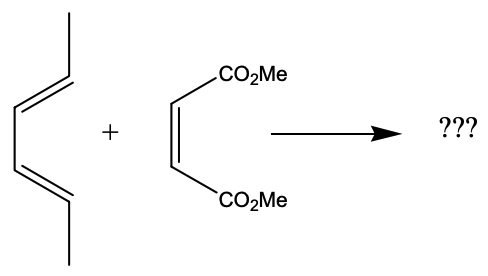

--> What are the SMILES strings for 2,4-hexadiene and dimethyl maleate?

### HOMO and LUMO of 2,4-hexadiene

--> Build an initial model of 2,4-hexadiene using the tool below.

In [ ]:
#@title Structure generation and visualization
#@markdown rdkit is used to generate the structure and add hydrogen atoms \\
#@markdown py3dmol is used to visualize the structure
smiles = 'C' #@param

from rdkit import Chem
from rdkit.Chem import AllChem

rdkit_mol = Chem.AddHs(Chem.MolFromSmiles(smiles))
AllChem.EmbedMolecule(rdkit_mol)

import py3Dmol
view = py3Dmol.view()
view.addModel(Chem.MolToMolBlock(rdkit_mol),'mol')
view.setStyle({'model':0}, {'stick': {}})
view.zoomTo()
view.show()

print(Chem.MolToXYZBlock(rdkit_mol))

In [ ]:
# Show a 2D representation of the molecule with indices labeled (starting 0)
dopts = Chem.Draw.rdMolDraw2D.MolDrawOptions()
dopts.addAtomIndices = True
display(Chem.Draw.MolsToGridImage([rdkit_mol], subImgSize=(600,600), drawOptions=dopts))

You should end up with the molecule in the *transoid* form.

--> Which dihedral atom (four atom indices) do you need to change to turn the molecule into the cisoid form shown above?

In the last notebook we set a bond angle using
`Chem.rdMolTransforms.SetAngleDeg(rdkit_mol.GetConformer(), 1, 0, 2, angle)` Look up the `Chem.rdMolTransforms` module for a function that sets the dihedral angle.

--> Modify the cell below to set the dihedral angle to 0 degrees.

In [ ]:
Chem.rdMolTransforms.SetDihedralDeg(rdkit_mol.GetConformer(), 1, 1, 1, 1, 0)

import py3Dmol
view = py3Dmol.view()
view.addModel(Chem.MolToMolBlock(rdkit_mol),'mol')
view.setStyle({'model':0}, {'stick': {}})
view.zoomTo()
view.show()

print(Chem.MolToXYZBlock(rdkit_mol))

In [ ]:
# Build the molecule
gto_mol = gto.Mole() # Gaussian-type orbitals
gto_mol.atom = Chem.MolToXYZBlock(rdkit_mol)[3:] # First two lines are number of atoms
gto_mol.verbose = False
gto_mol.basis = 'sto-3g' # Use a small basis set for faster convergence
gto_mol.build()
mf = scf.RHF(gto_mol).run()

# Constrained optimization of the geometry
params = {"constraints": "constraints.txt",}
with open('constraints.txt','w') as F:
  F.write(f"$set\ndihedral 2 3 4 5 0\n")
gto_mol_min = mf.Gradients().optimizer(solver='geomeTRIC').kernel(params)
mf_min = scf.RHF(gto_mol_min).run()

In [ ]:
# Visualize energies of the molecular orbitals
import matplotlib.pyplot as plt
plt.plot(mf_min.mo_energy,'.-')
plt.plot([0, mf_min.mo_coeff.shape[0]], [0, 0], 'k')
plt.xlabel('Molecular orbital index')
plt.ylabel('Energy');

--> How many electrons are in the system? Which molecular orbital index is the HOMO? Which molecular orbital index is the LUMO? Modify the code below. Remember that for python lists, indicies start at 0.

In [ ]:
mo_index = {}
mo_index['HOMO'] = 0
mo_index['LUMO'] = 1
print(f"The energy of the HOMO is {mf_min.mo_energy[mo_index['HOMO']]}" + \
      f" and LUMO is {mf_min.mo_energy[mo_index['LUMO']]} Hartrees")

In [ ]:
# Write volumetric data
from pyscf.tools import cubegen
resolution = 0.25
cubegen.orbital(gto_mol_min, 'HOMO.cube', \
  mf_min.mo_coeff[:,mo_index['HOMO']], resolution=resolution); # HOMO
cubegen.orbital(gto_mol_min, 'LUMO.cube', \
  mf_min.mo_coeff[:,mo_index['LUMO']], resolution=resolution); # LUMO

# Read volumetric data
vol = {}
for data_type in ['HOMO','LUMO']:
  vol[data_type] = open(data_type + ".cube", "r").read()

In [ ]:
# Show isosurfaces of the electron density, colored by electrostatic potential
v = py3Dmol.view(viewergrid=(1,2), linked=True)
v.addVolumetricData(vol['HOMO'], "cube", {'isoval': -0.03, 'color': "red", 'opacity': 0.75}, viewer=(0,0))
v.addVolumetricData(vol['HOMO'], "cube", {'isoval': 0.03, 'color': "blue", 'opacity': 0.75}, viewer=(0,0))
v.addModel(gto_mol_min.tostring('xyz'), 'xyz', viewer=(0,0))
v.setStyle({'stick':{}}, viewer=(0,0))
v.addVolumetricData(vol['LUMO'], "cube", {'isoval': -0.03, 'color': "red", 'opacity': 0.75}, viewer=(0,1))
v.addVolumetricData(vol['LUMO'], "cube", {'isoval': 0.03, 'color': "blue", 'opacity': 0.75}, viewer=(0,1))
v.addModel(gto_mol_min.tostring('xyz'), 'xyz', viewer=(0,1))
v.setStyle({'stick':{}}, viewer=(0,1))
v.zoomTo()
v.show()

### HOMO and LUMO of dimethyl maleate

--> Build an initial model of dimethyl maleate using the tool below.

In [ ]:
#@title Structure generation and visualization
#@markdown rdkit is used to generate the structure and add hydrogen atoms \\
#@markdown py3dmol is used to visualize the structure
smiles = 'C' #@param

from rdkit import Chem
from rdkit.Chem import AllChem

rdkit_mol = Chem.AddHs(Chem.MolFromSmiles(smiles))
AllChem.EmbedMolecule(rdkit_mol)

import py3Dmol
view = py3Dmol.view()
view.addModel(Chem.MolToMolBlock(rdkit_mol),'mol')
view.setStyle({'model':0}, {'stick': {}})
view.zoomTo()
view.show()

print(Chem.MolToXYZBlock(rdkit_mol))

In [ ]:
# Show a 2D representation of the molecule with indices labeled (starting 0)
dopts = Chem.Draw.rdMolDraw2D.MolDrawOptions()
dopts.addAtomIndices = True
display(Chem.Draw.MolsToGridImage([rdkit_mol], subImgSize=(600,600), drawOptions=dopts))

--> As before, rotate around the appropriate single bonds to achieve the structure shown below:

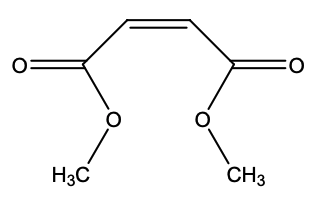

In [ ]:
Chem.rdMolTransforms.SetDihedralDeg(rdkit_mol.GetConformer(), 0, 0, 0, 0, 180)

import py3Dmol
view = py3Dmol.view()
view.addModel(Chem.MolToMolBlock(rdkit_mol),'mol')
view.setStyle({'model':0}, {'stick': {}})
view.zoomTo()
view.show()

print(Chem.MolToXYZBlock(rdkit_mol))

In [ ]:
# Build the molecule
gto_mol = gto.Mole() # Gaussian-type orbitals
gto_mol.atom = Chem.MolToXYZBlock(rdkit_mol)[3:] # First two lines are number of atoms
gto_mol.verbose = False
gto_mol.basis = 'sto-3g' # Use a small basis set for faster convergence
gto_mol.build()
mf = scf.RHF(gto_mol).run()

# Constrained optimization of the geometry
params = {"constraints": "constraints.txt",}
with open('constraints.txt','w') as F:
  F.write(f"$set\ndihedral 0 0 0 0 180\n")
gto_mol_min = mf.Gradients().optimizer(solver='geomeTRIC').kernel(params)
mf_min = scf.RHF(gto_mol_min).run()

In [ ]:
# Visualize energies of the molecular orbitals
import matplotlib.pyplot as plt
plt.plot(mf.mo_energy,'.-')
plt.plot([0, mf.mo_coeff.shape[0]], [0, 0], 'k')
plt.xlabel('Molecular orbital index')
plt.ylabel('Energy');

In [ ]:
gto_mol.nelectron

--> How many electrons are in the system? Which molecular orbital index is the HOMO? Which molecular orbital index is the LUMO? Modify the code below. Remember that for python lists, indicies start at 0.

In [ ]:
mo_index = {}
mo_index['HOMO'] = 0
mo_index['LUMO'] = 0
print(f"The energy of the HOMO is {mf_min.mo_energy[mo_index['HOMO']]}" + \
      f" and LUMO is {mf_min.mo_energy[mo_index['LUMO']]} Hartrees")

In [ ]:
# Write volumetric data
from pyscf.tools import cubegen
resolution = 0.25
cubegen.orbital(gto_mol_min, 'HOMO.cube', \
  mf_min.mo_coeff[:,mo_index['HOMO']], resolution=resolution); # HOMO
cubegen.orbital(gto_mol_min, 'LUMO.cube', \
  mf_min.mo_coeff[:,mo_index['LUMO']], resolution=resolution); # LUMO

# Read volumetric data
vol = {}
for data_type in ['HOMO','LUMO']:
  vol[data_type] = open(data_type + ".cube", "r").read()

In [ ]:
# Show isosurfaces of the electron density, colored by electrostatic potential
v = py3Dmol.view(viewergrid=(1,2), linked=True)
v.addVolumetricData(vol['HOMO'], "cube", {'isoval': -0.03, 'color': "red", 'opacity': 0.75}, viewer=(0,0))
v.addVolumetricData(vol['HOMO'], "cube", {'isoval': 0.03, 'color': "blue", 'opacity': 0.75}, viewer=(0,0))
v.addModel(gto_mol_min.tostring('xyz'), 'xyz', viewer=(0,0))
v.setStyle({'stick':{}}, viewer=(0,0))
v.addVolumetricData(vol['LUMO'], "cube", {'isoval': -0.03, 'color': "red", 'opacity': 0.75}, viewer=(0,1))
v.addVolumetricData(vol['LUMO'], "cube", {'isoval': 0.03, 'color': "blue", 'opacity': 0.75}, viewer=(0,1))
v.addModel(gto_mol_min.tostring('xyz'), 'xyz', viewer=(0,1))
v.setStyle({'stick':{}}, viewer=(0,1))
v.zoomTo()
v.show()

## Reaction

--> The HOMO on one molecule nearest in energy to the LUMO of the other molecule are the orbitals that will be involved in the reaction. What two orbitals will interact on these molecules?